In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tensorflow.keras.optimizers import Adam 
from swinTransformer import SwinTransformer
from util import PatchEmbedding, PatchMerging, PatchExtract
from loadDataset import load_data
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


x_train shape: (320, 64, 64) - y_train shape: (320, 2)
x_test shape: (80, 64, 64) - y_test shape: (80, 2)


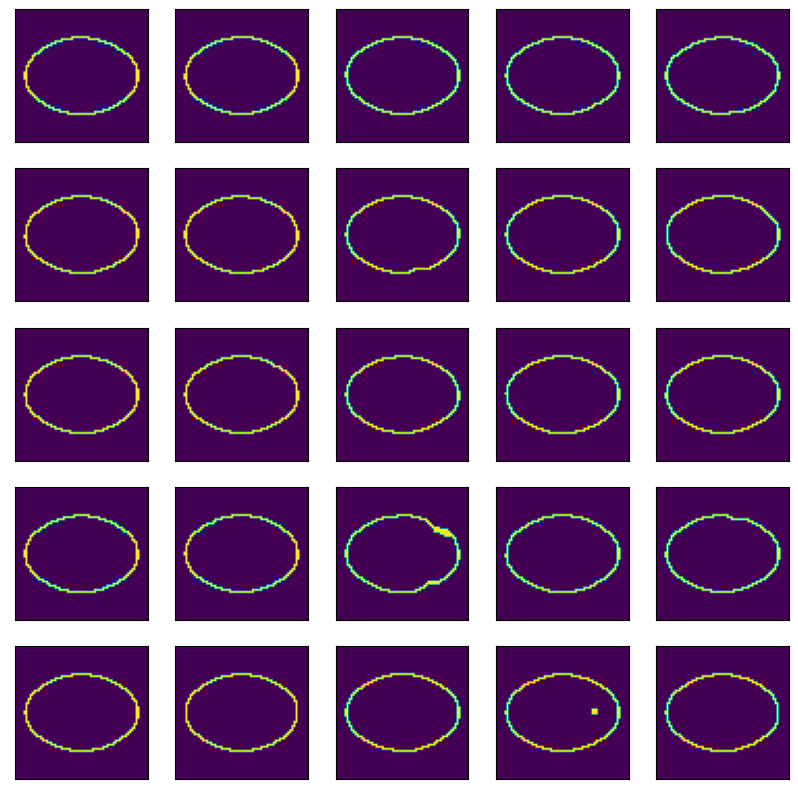

In [3]:
num_classes = 2
input_dim = 64
input_shape = (input_dim, input_dim, 1)

x_train, x_test, y_train, y_test = load_data(input_dim)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
plt.show()

In [4]:
patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.01  # Dropout rate
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 1  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = input_dim  # Initial image size

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 32
num_epochs = 20
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1

In [5]:
input = layers.Input(input_shape)
x = layers.RandomCrop(image_dimension, image_dimension)(input)
x = layers.RandomFlip("horizontal")(x)
x = PatchExtract(patch_size)(x)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes, activation="softmax")(x)

In [6]:
model = keras.Model(input, output)

# AdamW -> Adam 
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer= Adam(
        learning_rate=learning_rate,
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.Recall(name="recall"),
        keras.metrics.Precision(name="precision"),
    ],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=validation_split
)

Epoch 1/20
9/9 [==============================] - 11s 726ms/step - loss: 0.8909 - accuracy: 0.6111 - recall: 0.6111 - precision: 0.6111 - val_loss: 0.7083 - val_accuracy: 0.7188 - val_recall: 0.7188 - val_precision: 0.7188
Epoch 2/20
9/9 [==============================] - 5s 585ms/step - loss: 0.6302 - accuracy: 0.7326 - recall: 0.7326 - precision: 0.7326 - val_loss: 0.6211 - val_accuracy: 0.7188 - val_recall: 0.7188 - val_precision: 0.7188
Epoch 3/20
9/9 [==============================] - 5s 598ms/step - loss: 0.6080 - accuracy: 0.7326 - recall: 0.7326 - precision: 0.7326 - val_loss: 0.6246 - val_accuracy: 0.7188 - val_recall: 0.7188 - val_precision: 0.7188
Epoch 4/20
9/9 [==============================] - 5s 578ms/step - loss: 0.6195 - accuracy: 0.7292 - recall: 0.7292 - precision: 0.7292 - val_loss: 0.6279 - val_accuracy: 0.7188 - val_recall: 0.7188 - val_precision: 0.7188
Epoch 5/20
9/9 [==============================] - 5s 532ms/step - loss: 0.6149 - accuracy: 0.7326 - recall: 0.7

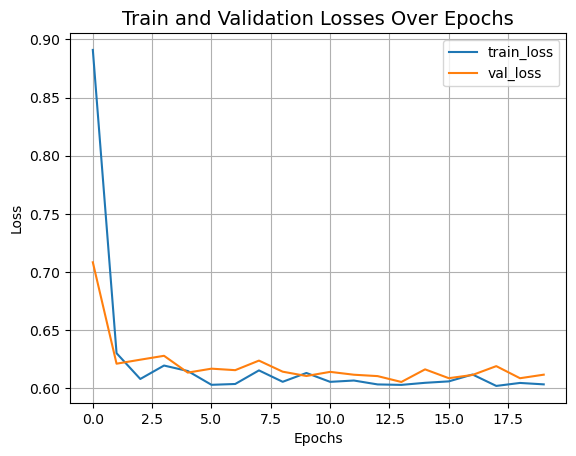

In [7]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [8]:
loss, accuracy, recall, precision = model.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test f1_score: {round(2 * (precision * recall) / (precision + recall), 2)}")
print(f"Test precision: {round(precision, 2)}")
print(f"Test recall: {round(recall, 2)}")

3/3 [==============================] - 1s 131ms/step - loss: 0.5909 - accuracy: 0.7375 - recall: 0.7375 - precision: 0.7375
Test loss: 0.59
Test accuracy: 73.75%
Test f1_score: 0.74
Test precision: 0.74
Test recall: 0.74


In [10]:
model.save_weights(f"./model/enhanceS_{input_dim}dim_{batch_size}batch_{round(loss, 2)}_{round(accuracy, 2)}.h5")

ValueError: Unable to create dataset (name already exists)